# $\text{Jane Street Market Prediction}$


Contents:
1. Data wrangling
3. Model training and evaluation pipelines
3. Model fitting and evaluation
4. EDA

Note: EDA is placed at the end because it takes a lot of place. Important insights are explained in first section of accompanying paper.

## $\text{Getting the data}$

In [171]:
# Data
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 500) #arbitrary large number, I wanna see all columns


# Plotting
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

#utilities
import os
from collections import Counter


In [172]:
%%time
working_dir = "/Users/oscarengelbrektson/Documents/Minerva/Spring 2021 - San Francisco/Quantitative Trading/Jane Street Competition/data/"

train_data = pd.read_csv(working_dir + "train.csv")
test_data_sample = pd.read_csv(working_dir + "example_test.csv")
feature_data = pd.read_csv(working_dir + "features.csv")



CPU times: user 59.1 s, sys: 14.1 s, total: 1min 13s
Wall time: 1min 17s


In [173]:
#Which of columns that exist in train data do not exist in test data?
set(train_data.columns) - set(test_data_sample.columns)

{'resp', 'resp_1', 'resp_2', 'resp_3', 'resp_4'}

# Feature engineering

## Constructing a target variable
It can be shown that the Janestreet utility function is maximized if one takes every trade with a positive resp. Consequently, we define a target variable
    
    action = 1 if resp > 0, else 0

In [174]:
train_data["action"] = train_data["resp"].apply(lambda x: int(x>0))

In [175]:
#How many trading opportunities should ideally be acted on?
Counter(train_data["action"])

Counter({1: 1204974, 0: 1185517})

The dataset is balanced wrt to classes. Approximately half of all trading opportunities should be acted on by a theoretically optimal model.

## Imputing missing values using linear interpolation

In [177]:
#Use impute missing values with previous non-missing observation for column
train_data = train_data.fillna(method="ffill", axis=1)

### Dropping 'resp_1', 'resp_2', 'resp_3', 'resp_4' and features associated only with them


Approach:
1. Identify tags that are associated with (not resp)
2. Identify features associated with tags from (1)
3. Drop features from (2) from train_df

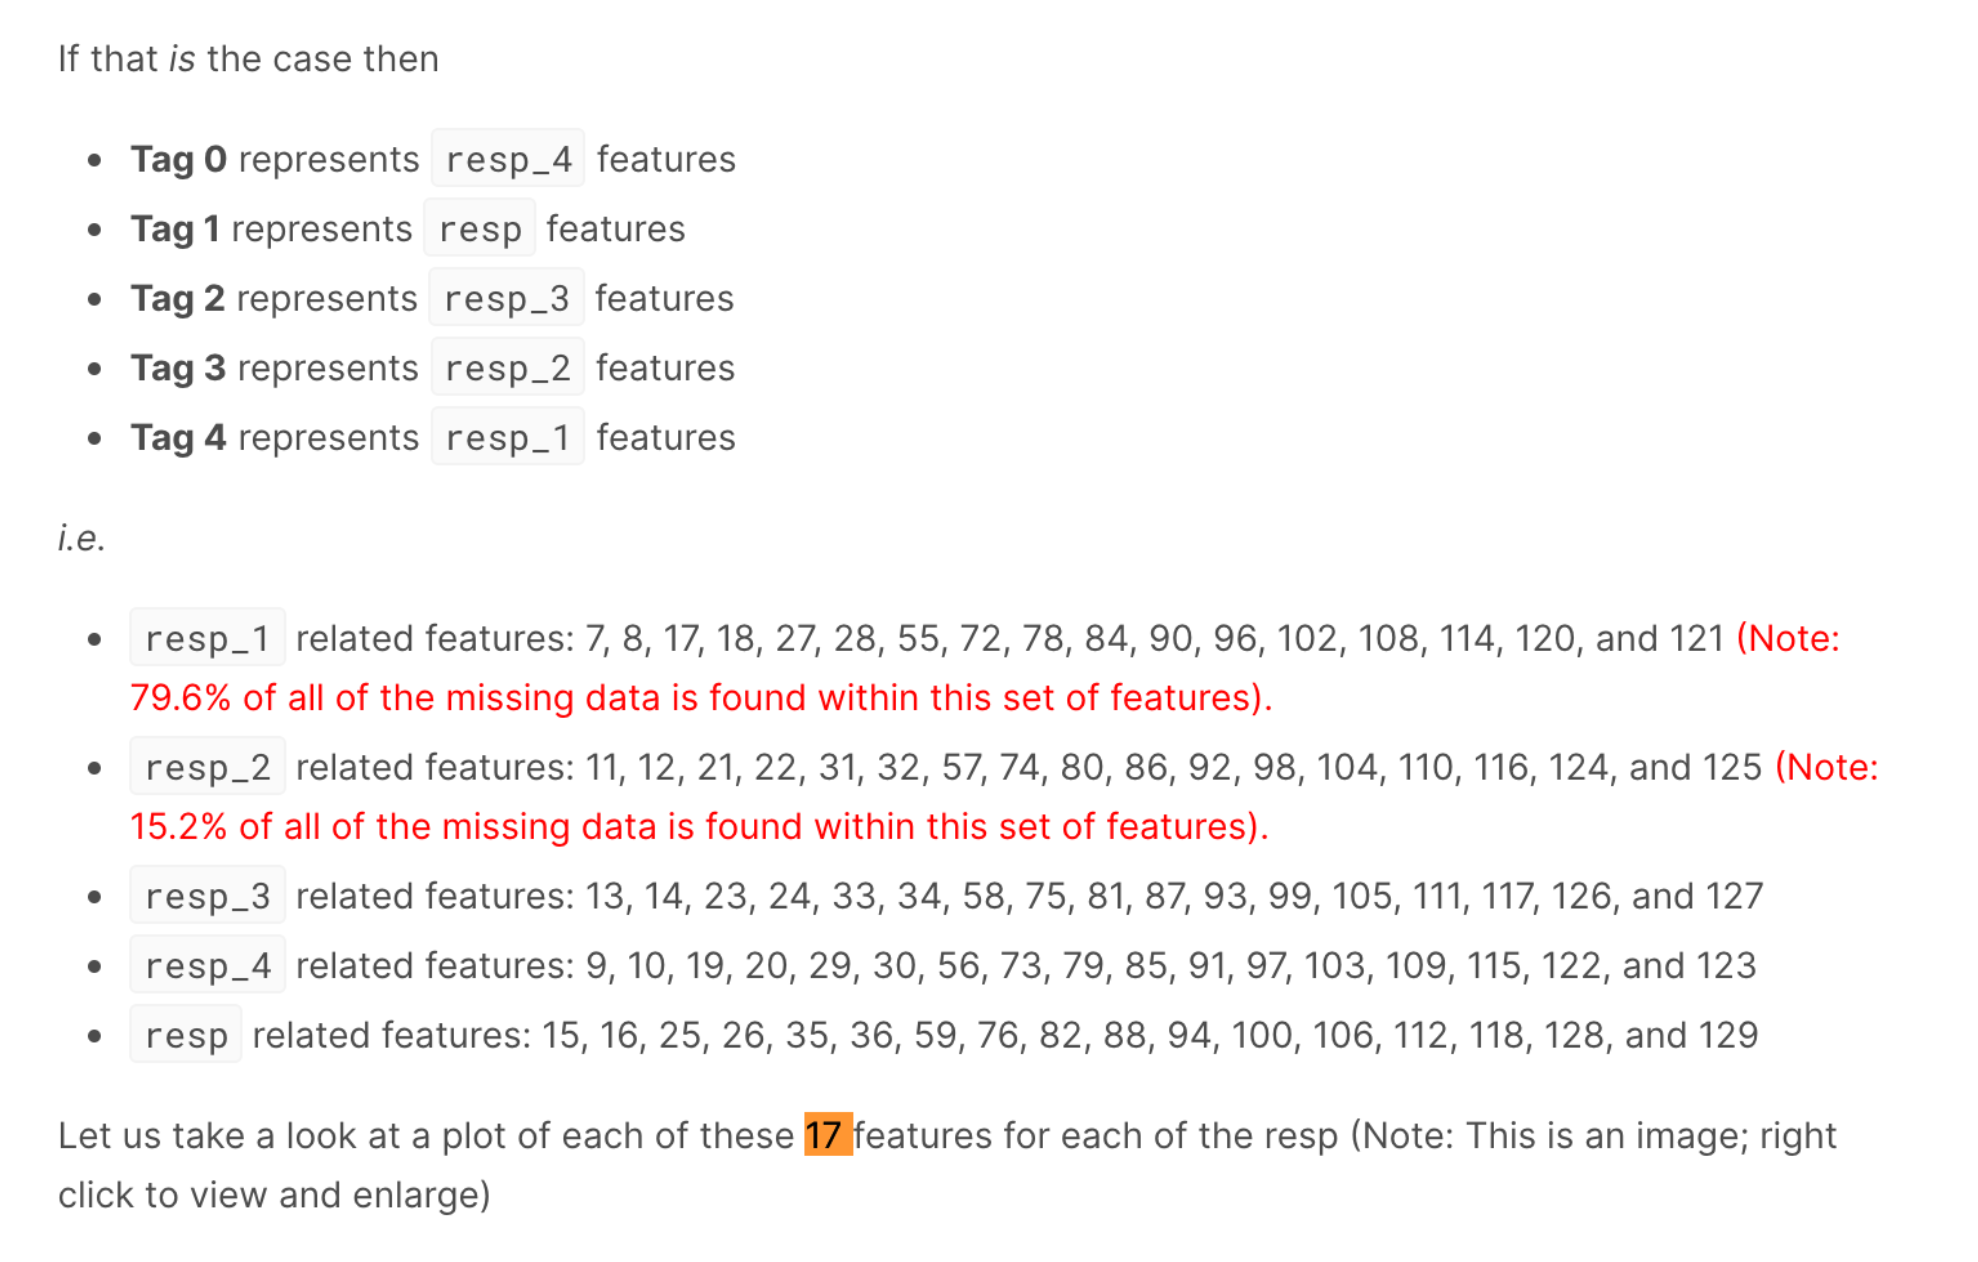

In [ ]:
'''
#Step 1
not_resp_tags = ["tag_0", "tag_2", "tag_3", "tag_4"]

#Step 2
not_resp_features = feature_data.loc[np.any(feature_data[not_resp_tags] == True, axis=1)]["feature"]

#Step 3
train_data.drop(columns=not_resp_features, axis=0, inplace=True)
train_data.drop(columns=["resp_%d"%x for x in range(1, 5)], axis=0, inplace=True)
'''

In [ ]:
#Check the shape is expected: 66 features should remain after dropping
train_data.shape[1] == 66

## $\text{Training and testing pipelines}$

### Implementing the utility score function from Jane Street
https://www.kaggle.com/c/jane-street-market-prediction/overview/evaluation
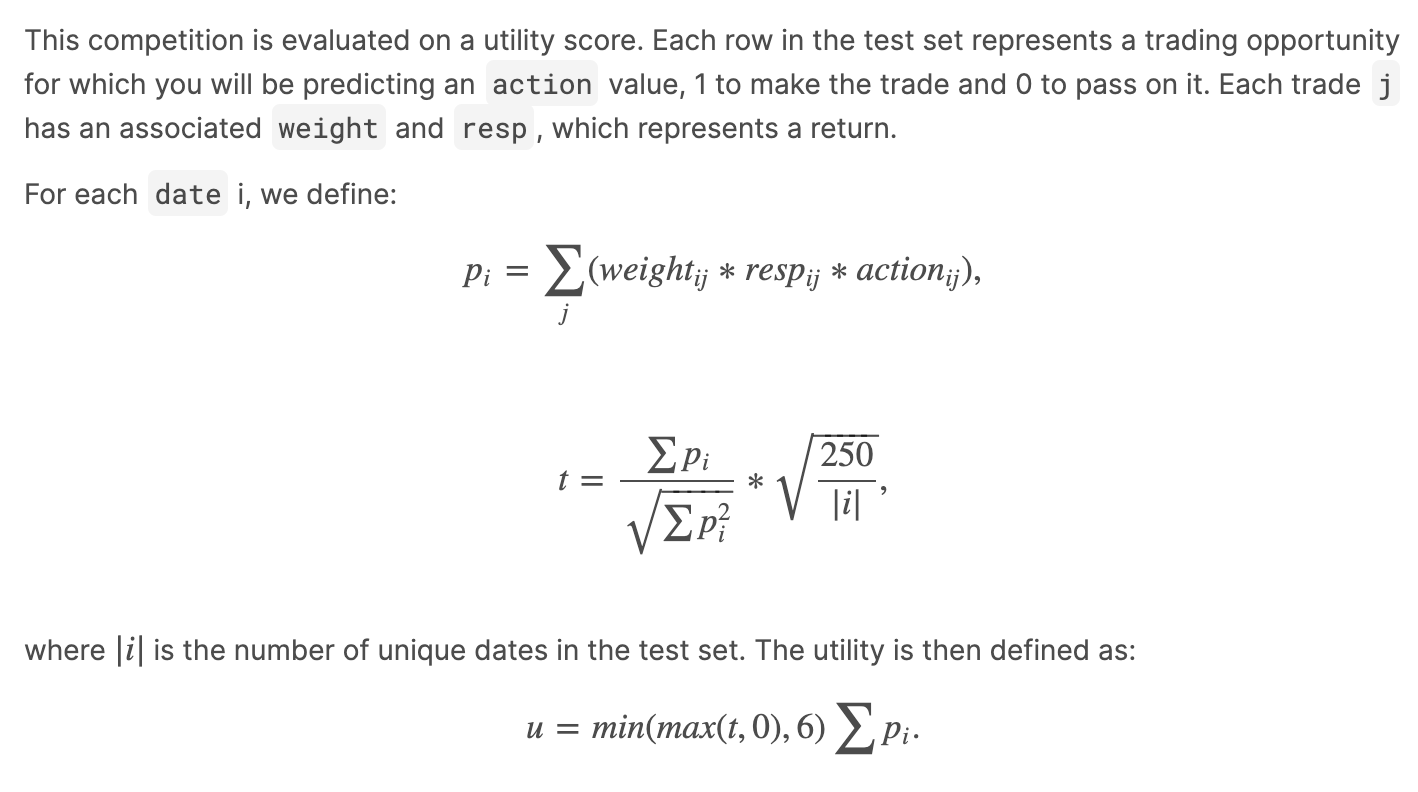

In [178]:
def utility_score_last(date, weight, resp, action):
    count_i = date[-1] + 1 #Get number of days
    P_i = np.bincount(date, weight * resp * action) #Compute P_i
    t = np.sum(P_i) / np.sqrt(np.sum(P_i ** 2)) * np.sqrt(250 / count_i) #Compute t
    u = np.clip(t, 0, 6) * np.sum(P_i) #combine to get utility score
    return u

## Model training and selection pipeline

We take the following approach to model selection and evaluation:
1. Divide the data into a test set and a train set, where the test set contains all observations temporally after the last observation of the train set.
2. Split the train set into k subsets of equal size, as measured in the number of days, where train_data.shape[0]/k is large enough to train the model. In our case, we choose k = 4 so that we have ~75 days of trading per subset.
3. For each hyperparameter setting, repeat the following procedure:
    1. Fit the model on the first training subset, evaluating performance, as measured by accuracy, on the second subset.
    2. Repeat, but this time training on the first and the second subset and validating on the third.
    3. Repeat until the last subset is validated on.
    4. Average performance achieved for each of the previous steps. This is the overall training performance of the hyperparameter setting for the model.
4. Using the model from 3, find the decision threshhold that would have maximised the utility score.
3. Using the model hyperparameters that which optimized performance in 3, fit the model to the entire train set.
4. Evaluate performance of model from previous step on the test set. This is the performance of the model, and is recorded in the model_evaluation_df.


Implementation steps:
2. Implement procedure for a simple model
2. Implement custom scoring function
3. Make the model and parameters an arguments that can be changed


### Train-test split

In [179]:
#Drop first 85 days
cropped_train_data = train_data.loc[train_data.date > 85]

In [180]:
#We want 3 validation sets and a test set. 3 validation sets requries 4 train subsets -> we need 5 splits
train_days = cropped_train_data["date"].nunique()
days_in_test = train_days*0.12  #tweaked the subtraction constant to end up with ~15% of data for test
print("Days per split, if 5 splits:", days_in_test)

#Take 4 splits into train
train_set = cropped_train_data.loc[cropped_train_data.date <= (cropped_train_data.date.max() - days_in_test)]

#Take last 1 split into test
test_set = cropped_train_data.loc[cropped_train_data.date > cropped_train_data.date.max() - days_in_test]

Days per split, if 5 splits: 49.68


In [181]:
#Let's see how many trades are in train and test

print("train_df:", train_set.shape)
print("test_Df:", test_set.shape)

train_df: (1584282, 139)
test_Df: (278315, 139)


In [182]:
#Test set constitutes 23% of total data, this seems good.
test_set.shape[0] / (train_set.shape[0]+test_set.shape[0])

0.14942309044844376

### Dataframe to store results


In [183]:
#Dataframe to store results
model_evaluation_df = pd.DataFrame({"model":[],
                                    "hyperparams":[],
                                    "validation_1": [],
                                    "validation_2": [],
                                    "validation_3": [],
                                    "test": []})
model_evaluation_df.head()

Empty DataFrame
Columns: [model, hyperparams, validation_1, validation_2, validation_3, test]
Index: []

## Custom objective function: utility score

The utility score provided by Jane Street complicates model training because the model has to make a decision on every trade, but the performance is evaluated on a daily basis.

Documentation: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html

In [184]:
def utility_score_last(date, weight, resp, action):
    count_i = date[-1] + 1 #Get number of days
    P_i = np.bincount(date, weight * resp * action) #Compute P_i
    t = np.sum(P_i) / np.sqrt(np.sum(P_i ** 2)) * np.sqrt(250 / count_i) #Compute t
    u = np.clip(t, 0, 6) * np.sum(P_i) #combine to get utility score
    return u

## Actual pipeline

In [185]:
train_data.columns

Index(['date', 'weight', 'resp_1', 'resp_2', 'resp_3', 'resp_4', 'resp',
       'feature_0', 'feature_1', 'feature_2',
       ...
       'feature_122', 'feature_123', 'feature_124', 'feature_125',
       'feature_126', 'feature_127', 'feature_128', 'feature_129', 'ts_id',
       'action'],
      dtype='object', length=139)

In [186]:
predictors = ['weight', 'feature_0', 'feature_1', 'feature_2',
               'feature_3', 'feature_4', 'feature_5', 'feature_6', 'feature_15',
               'feature_16', 'feature_25', 'feature_26', 'feature_35', 'feature_36',
               'feature_37', 'feature_38', 'feature_39', 'feature_40', 'feature_41',
               'feature_42', 'feature_43', 'feature_44', 'feature_45', 'feature_46',
               'feature_47', 'feature_48', 'feature_49', 'feature_50', 'feature_51',
               'feature_52', 'feature_53', 'feature_54', 'feature_59', 'feature_60',
               'feature_61', 'feature_62', 'feature_63', 'feature_64', 'feature_65',
               'feature_66', 'feature_67', 'feature_68', 'feature_69', 'feature_70',
               'feature_71', 'feature_76', 'feature_77', 'feature_82', 'feature_83',
               'feature_88', 'feature_89', 'feature_94', 'feature_95', 'feature_100',
               'feature_101', 'feature_106', 'feature_107', 'feature_112',
               'feature_113', 'feature_118', 'feature_119', 'feature_128',
               'feature_129', 'ts_id', 'date']

outcome = ["action"]

In [187]:
#Parameters for lightGBM. Objective is minimizing logloss
params = {'learning_rate': 0.01,
          'boosting': 'gbdt',
          'objective': 'binary',
          'num_leaves': 200,
          'min_data_in_leaf': 10,
          'max_bin': 200,
          'max_depth': 6,
          'seed': 2018,
          'nthread': 10}

In [188]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score
import lightgbm as lgb

def train_model_w_strat_cv(predictors, params=params):
    '''
    '''
        
    X_train, y_train = train_set[predictors], train_set[outcome]
    X_test, y_test = test_set[predictors], test_set[outcome].values.reshape(-1,)

    #Cross-validation
    ts = TimeSeriesSplit(n_splits=4)
    predictions_list = []
    
    model_dict = {}
    #train on fold index, evaluate on hold_out
    
    for fold_index, holdout_index in ts.split(X_train, y_train): 
        
        #Create holdout and train sets for the current split
        X_fold, X_holdout = X_train.iloc[fold_index,:], X_train.iloc[holdout_index,:]
        y_fold, y_holdout = y_train.iloc[fold_index,:], y_train.iloc[holdout_index,:]
        
        #Create lgb datasets
        train_data = lgb.Dataset(data=X_fold,label=y_fold, feature_name="auto", categorical_feature="auto")#, categorical_feature="initial_proficiency_6")
        validation_data = lgb.Dataset(X_holdout,label=y_holdout, feature_name=predictors, reference=train_data)
        test_data = lgb.Dataset(X_test,label=y_test, feature_name=predictors, reference=train_data)

        #Fit model
        model = lgb.train(params, train_data, valid_sets=[validation_data], 
                          early_stopping_rounds=30, verbose_eval=False,
                         num_boost_round=1000)
        
        #Make predictions for test set with model trained on current fold
        predictions = model.predict(X_test)
        predictions_list.append(predictions)
    
    #Average the predictions made by the 5 models
    avg_predictions = np.mean(predictions_list, axis=0)
    
    #Report metrics and return
    rounded_predictions = np.round(avg_predictions)
    print("AUC:", roc_auc_score(y_test, avg_predictions))
    
    train_predictions = model.predict(X_train)
    return model, X_test, y_test, avg_predictions, X_train, train_predictions, y_train

In [189]:
all_predictors_model, X_test, y_test, predictions, X_train, train_predictions, y_train = train_model_w_strat_cv(predictors)

[LightGBM] [Info] Number of positive: 159981, number of negative: 156877
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.164491 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12689
[LightGBM] [Info] Number of data points in the train set: 316858, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504898 -> initscore=0.019593
[LightGBM] [Info] Start training from score 0.019593
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positiv

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [190]:
from sklearn.metrics import confusion_matrix

def confusion_mat(y_test, predictions):
    cm = confusion_matrix(y_test,  np.round(predictions))
    print('Confusion matrix\n\n', cm)
    print('\nTrue Positives(TP) = ', cm[0,0])
    print('\nTrue Negatives(TN) = ', cm[1,1])
    print('\nFalse Positives(FP) = ', cm[0,1])
    print('\nFalse Negatives(FN) = ', cm[1,0])

confusion_mat(y_test, predictions)

Confusion matrix

 [[50737 88148]
 [47543 91887]]

True Positives(TP) =  50737

True Negatives(TN) =  91887

False Positives(FP) =  88148

False Negatives(FN) =  47543


In [191]:
from sklearn.metrics import classification_report
print(classification_report(y_test, np.round(predictions)))

              precision    recall  f1-score   support

         0.0       0.52      0.37      0.43    138885
         1.0       0.51      0.66      0.58    139430

    accuracy                           0.51    278315
   macro avg       0.51      0.51      0.50    278315
weighted avg       0.51      0.51      0.50    278315



In [192]:
#Compute accuracy for different decision thresholds
from sklearn.metrics import accuracy_score

def accuracy(boundary, y_true=y_test, predictions=predictions):
    '''Produces'''
    return accuracy_score(y_true, [1 if x > boundary else 0 for x in predictions])

accuracy_df = pd.DataFrame({"threshold":np.linspace(0, 1, 250)})
accuracy_df["accuracy"] = accuracy_df["threshold"].apply(accuracy)
accuracy_df["train_accuracy"] = accuracy_df["threshold"].apply(accuracy, args=(y_train, train_predictions))

#Get threshold with highest accuracy
best_threshold = accuracy_df.loc[accuracy_df["accuracy"]==accuracy_df["accuracy"].max()]["threshold"].iloc[0]

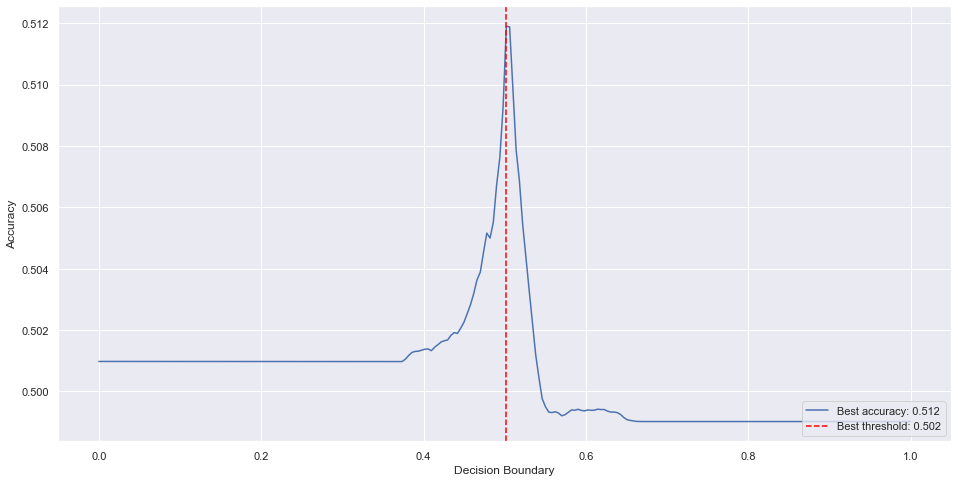

In [193]:
import matplotlib.pyplot as plt 

# Visualize
plt.figure(figsize=(16, 8))
plt.plot(accuracy_df["threshold"], accuracy_df["accuracy"], label="Best accuracy: %s"%np.round(accuracy_df["accuracy"].max(), 3))
plt.axvline(best_threshold, 
            color="red", linestyle="--",label="Best threshold: %s"%np.round(best_threshold, 3))
plt.ylabel("Accuracy")
plt.xlabel("Decision Boundary")
plt.legend(loc=4)
plt.show()

# ROC curve
https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

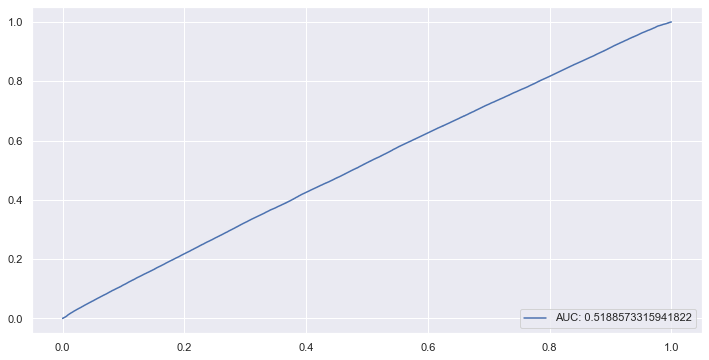

In [194]:
plt.figure(figsize=(12, 6))
fpr, tpr, _ = roc_curve(y_test,  predictions)
auc = roc_auc_score(y_test, predictions)
plt.plot(fpr,tpr,label="AUC: %s"%roc_auc_score(y_test, predictions))
plt.legend(loc=4)
plt.show()

## $\text{EDA}$

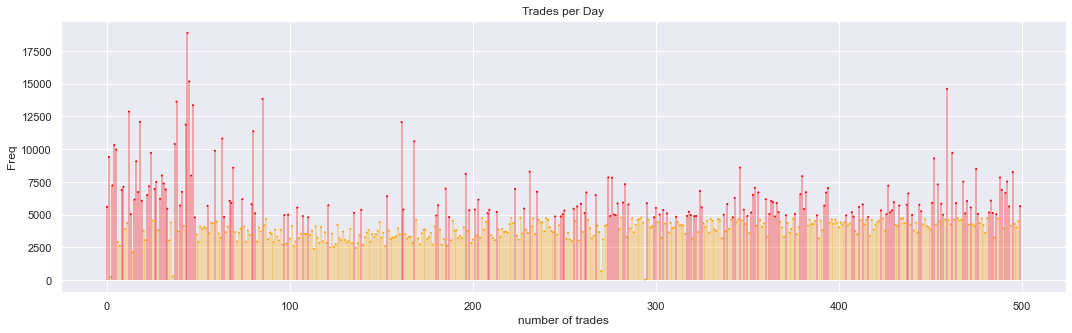

In [28]:
plt.figure(figsize=(18, 5))

y = train_data.date.value_counts().values
x = train_data.date.value_counts().index
color = np.where(y < np.mean(y), 'orange', 'red')

plt.vlines(x=x, ymin=0, ymax=y, alpha=0.4, color=color); plt.scatter(x, y, color=color, s=1)
plt.title('Trades per Day'); plt.xlabel('number of trades'); plt.ylabel('Freq');

In [32]:
train_data.groupby("date").shape

AttributeError: 'DataFrameGroupBy' object has no attribute 'shape'

In [ ]:
# Percentage of trades with 0 weights
round((100/train_data.shape[0])*((train_data.weight.values == 0).sum()), 3)

17.118

In [ ]:
# The trade with maximum weight
maxi = train_data.iloc[np.argmax(train_data['weight'])]
print('Max weight: {}\nOn day: {}\nResp: {}'.format(maxi['weight'], maxi['date'], maxi['resp']))

# The trade with minimum weight
mini = train_data[train_data.weight!=0].iloc[np.argmin(train_data[train_data.weight!=0]['weight'])]
print('\nMin weight: {}\nOn day: {}\nResp: {}'.format(mini['weight'], mini['date'], mini['resp']))

Max weight: 167.2937151011765
On day: 446.0
Resp: -0.0012154205449118071

Min weight: 0.006912442388440349
On day: 16.0
Resp: -0.015811082686868972


In [ ]:
# Correlation between any pair of dates (e.g., 100 and 200)

pd.concat([train_data.loc[train_data['date'] == 100], train_data.loc[train_data['date'] == 200]]).\
    corr(method='pearson').style.background_gradient(
    cmap='coolwarm', axis=None).set_precision(2)

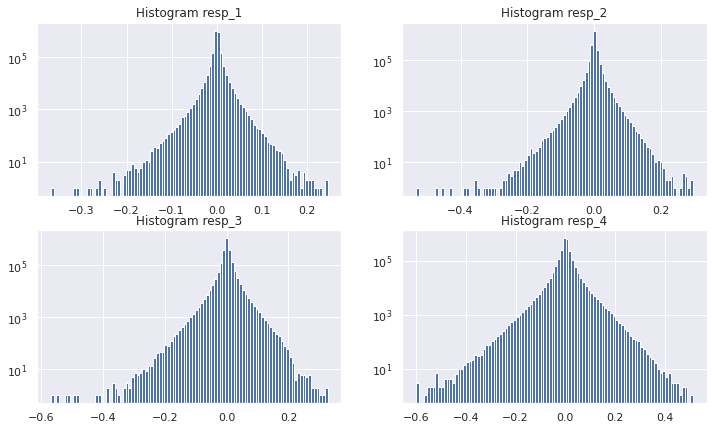

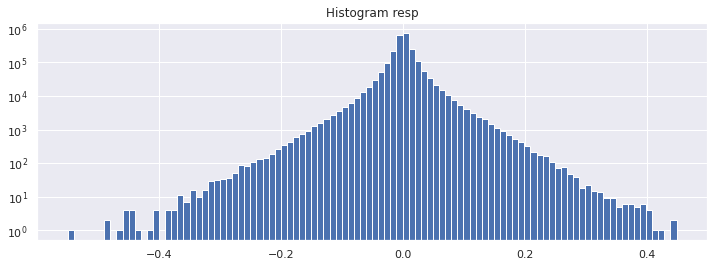

In [ ]:
resp_df = ['resp_1', 'resp_2', 'resp_3', 'resp_4']

plt.figure(figsize=(12, 7))
for idx, column in enumerate(resp_df):
    plt.subplot(2, 2, idx+1)
    plt.title('Histogram '+column)
    plt.hist(train_data[column], bins=100, log=True)
plt.show()

plt.figure(figsize=(12, 4)); plt.title('Histogram resp')
plt.hist(train_data['resp'], bins=100, log=True);

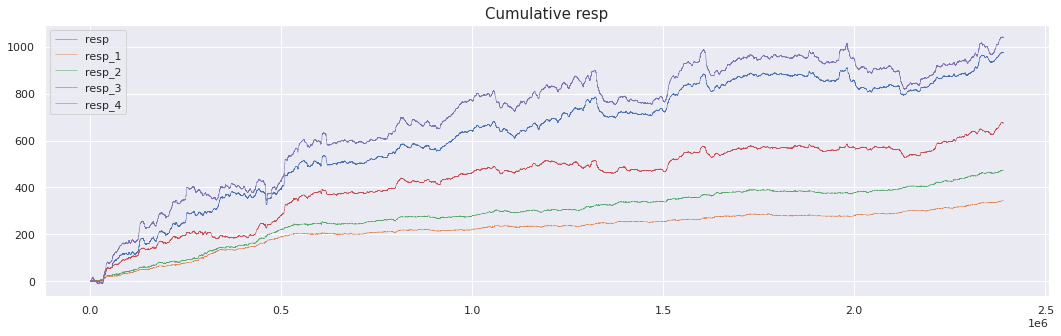

In [ ]:
fig, ax = plt.subplots(figsize=(18, 5))

for i in ['resp','resp_1','resp_2','resp_3','resp_4']:
    train_data[i].cumsum().plot(lw=.5)
    
plt.legend(); plt.title('Cumulative resp', fontsize=15);

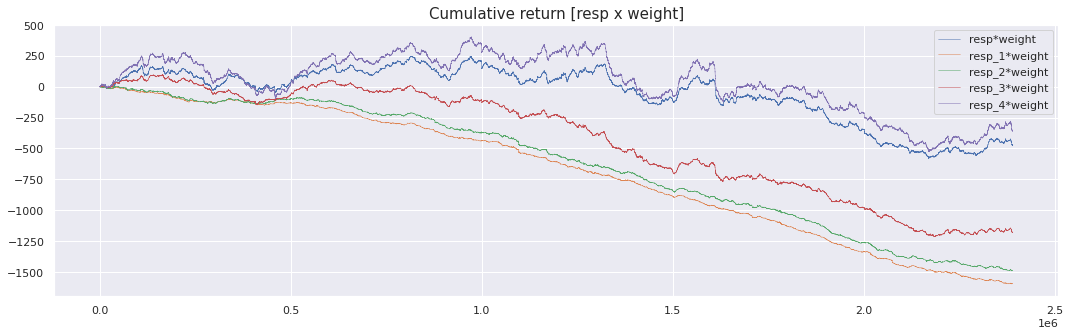

In [ ]:
fig, ax = plt.subplots(figsize=(18, 5))

for i in ['resp','resp_1','resp_2','resp_3','resp_4']:
    (train_data[i]*train_data['weight']).cumsum().plot(lw=.5, label=i+'*weight')
    
plt.legend(); plt.title('Cumulative return [resp x weight]', fontsize=15);

In [ ]:
from fbprophet import *
import plotly.offline as py
import plotly.graph_objs as go

In [ ]:
return_data = pd.DataFrame(np.array([train_data.ts_id, (train_data.weight*train_data.resp).cumsum()]).T, columns=['ds', 'y'])
return_data.head()

ds         y
0  0.0  0.000000
1  1.0 -0.163262
2  2.0 -0.163262
3  3.0 -0.163262
4  4.0 -0.163622

In [ ]:
train_data['weight_resp'] = train_data['weight']*train_data['resp']
resp = pd.Series(1+(train_data.groupby('date')['resp'].mean())).cumprod()

import datetime
base = datetime.datetime.today()
date_list = [base - datetime.timedelta(days=x) for x in range(500)]
resp_data = pd.DataFrame(resp.to_frame().values, columns=['y'])
resp_data['ds'] = date_list

resp_data.head()

y                         ds
0  1.002285 2021-02-23 17:17:25.154593
1  1.001087 2021-02-22 17:17:25.154593
2  1.001853 2021-02-21 17:17:25.154593
3  1.000447 2021-02-20 17:17:25.154593
4  1.000782 2021-02-19 17:17:25.154593

INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


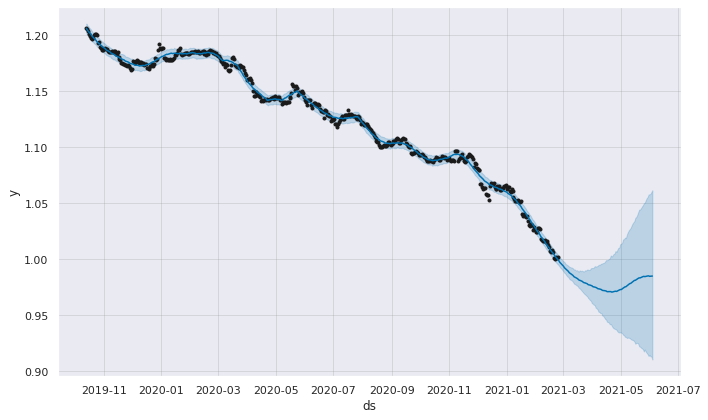

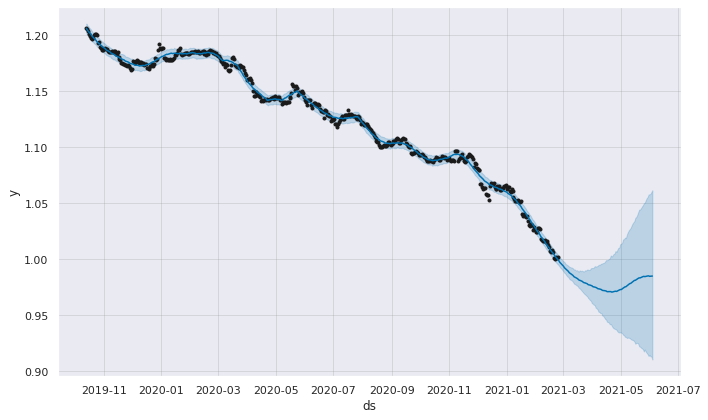

In [ ]:
model = Prophet()
model.set_auto_seasonalities
model.add_seasonality(name='weekly', period=5, fourier_order=5)
model.add_seasonality(name='yearly', period=250, fourier_order=5)

model.fit(resp_data)
future = model.make_future_dataframe(periods=100)
forecast = model.predict(future)
plot.plot(model, forecast)

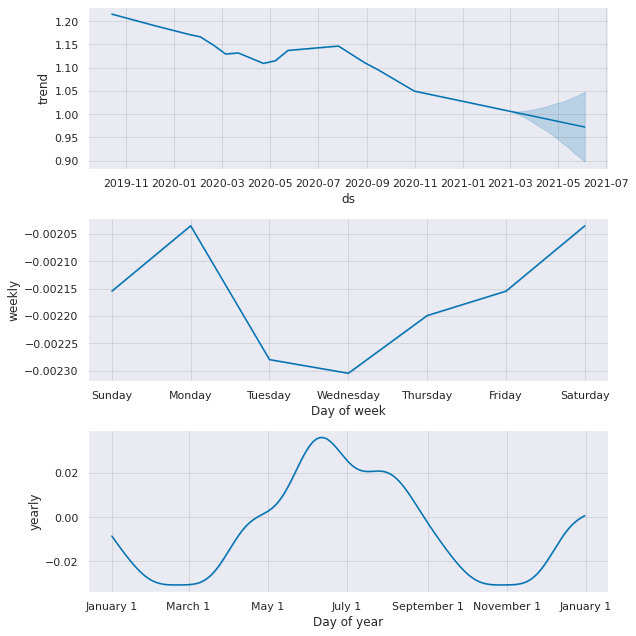

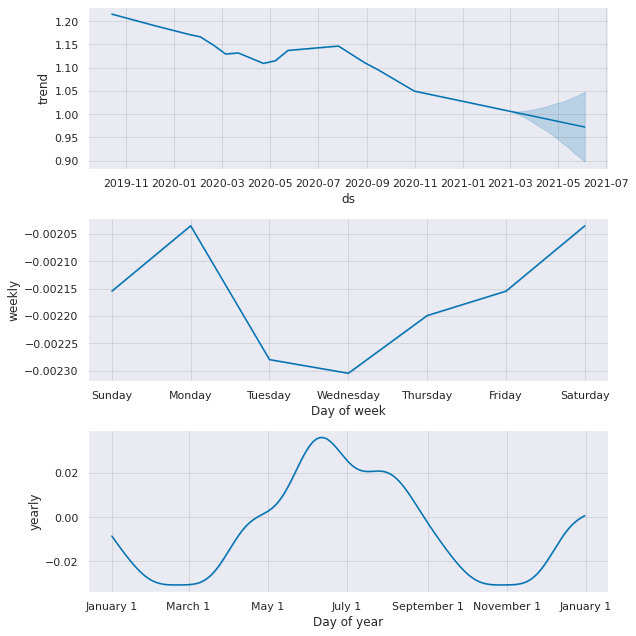

In [ ]:
plot.plot_components(model, forecast)